# 3. Backfill News Data with FinBERT Sentiment (Aggregated)

Fetch historical news articles, apply FinBERT sentiment analysis, and aggregate to **daily sentiment metrics**.

**Key Change**: We aggregate sentiment to daily metrics (no text columns) to avoid Hopsworks free tier limitations.

**Pipeline**: NewsAPI → FinBERT → Daily Aggregation → Hopsworks FG

**Features Created**:
- `sentiment_mean`: Average daily compound sentiment
- `sentiment_std`: Standard deviation of daily sentiment
- `article_count`: Number of articles per day
- `positive_mean`, `negative_mean`, `neutral_mean`: Average sentiment scores

In [1]:
import sys
sys.path.append('..')

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils.data_fetchers import fetch_news_articles, apply_finbert_sentiment
from utils.feature_functions import aggregate_sentiment
from utils.hopsworks_helpers import get_feature_store, create_feature_group
from dotenv import load_dotenv
import yaml
from datetime import datetime, timedelta
from tqdm import tqdm
import time

load_dotenv()

# Load config
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

## Load FinBERT Model

In [2]:
# Load FinBERT for financial sentiment analysis
print("Loading FinBERT model...")
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

print("✓ FinBERT model loaded successfully")

Loading FinBERT model...
✓ FinBERT model loaded successfully


## Fetch News Articles and Apply Sentiment Analysis

**Note**: NewsAPI free tier has limits (100 requests/day). For full backfill:
- Run this over multiple days, OR
- Use a paid plan, OR
- Sample specific dates

**Fallback**: If NewsAPI key is invalid, you can use alternative sources like Finnhub or Alpha Vantage.

In [3]:
# Fetch last 30 days of news as demonstration
# Adjust based on your NewsAPI plan and data needs

end_date = datetime.strptime(config['data']['end_date'], '%Y-%m-%d')
start_date = end_date - timedelta(days=29)  # Last 30 days

query = config['data']['news']['query']
all_articles = []

print(f"Fetching news from {start_date.date()} to {end_date.date()}...")
print(f"Query: '{query}'\n")

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime('%Y-%m-%d')
    
    try:
        articles = fetch_news_articles(query, date_str, max_articles=100)
        
        if articles:
            print(f"{date_str}: {len(articles)} articles")
            
            for article in articles:
                # Combine title and description for sentiment analysis
                text = f"{article.get('title', '')} {article.get('description', '')}"
                
                # Skip if no text
                if not text.strip():
                    continue
                
                # Apply FinBERT
                sentiment = apply_finbert_sentiment(text, model, tokenizer)
                
                all_articles.append({
                    'date': date_str,
                    **sentiment  # compound, positive, negative, neutral
                })
        
        # Respect API rate limits
        time.sleep(1)
        
    except Exception as e:
        error_msg = str(e)
        
        # Check if API key is invalid
        if 'apiKeyInvalid' in error_msg or 'API key' in error_msg:
            print(f"\n❌ ERROR: Invalid NewsAPI key")
            print(f"\nTo fix this:")
            print(f"1. Get a free API key from https://newsapi.org/register")
            print(f"2. Update NEWS_API_KEY in your .env file")
            print(f"3. Re-run this notebook\n")
            print(f"\nAlternatively, you can use Finnhub (free tier):")
            print(f"1. Get API key from https://finnhub.io/register")
            print(f"2. Modify fetch_news_articles() to use Finnhub instead")
            break
        else:
            print(f"{date_str}: Error - {error_msg}")
    
    current_date += timedelta(days=1)

# Create DataFrame with article-level sentiment
articles_df = pd.DataFrame(all_articles)
print(f"\n✓ Total articles fetched: {len(articles_df)}")

if len(articles_df) > 0:
    print(f"  Date range: {articles_df['date'].min()} to {articles_df['date'].max()}")
    print(f"\nSample article-level sentiment:")
    print(articles_df.head())
else:
    print("\n⚠️  No articles fetched. Check your API key or try alternative data source.")

Fetching news from 2025-12-01 to 2025-12-30...
Query: 'QQQ OR Nasdaq OR technology stocks OR big tech'

2025-12-01: Error - {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2025-12-04, but you have requested 2025-12-01. You may need to upgrade to a paid plan.'}
2025-12-02: Error - {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2025-12-04, but you have requested 2025-12-02. You may need to upgrade to a paid plan.'}
2025-12-03: Error - {'status': 'error', 'code': 'parameterInvalid', 'message': 'You are trying to request results too far in the past. Your plan permits you to request articles as far back as 2025-12-04, but you have requested 2025-12-03. You may need to upgrade to a paid plan.'}
2025-12-04: Error - {'status': 'error', 'code': 'para

## Alternative: Load Sample News Data (if NewsAPI fails)

If you don't have a valid NewsAPI key, you can:
1. Use the sample data below for testing
2. Manually create a CSV with article-level sentiment
3. Use alternative news APIs (Finnhub, Alpha Vantage)

**Uncomment the cell below to use sample data for testing:**

In [4]:
# ONLY USE THIS IF NEWSAPI FAILED ABOVE
# This creates sample sentiment data for testing the pipeline

# import numpy as np
# 
# # Generate sample news sentiment data (30 days, random articles per day)
# sample_data = []
# 
# for i in range(30):
#     date = (end_date - timedelta(days=29-i)).strftime('%Y-%m-%d')
#     num_articles = np.random.randint(5, 20)  # 5-20 articles per day
#     
#     for _ in range(num_articles):
#         # Random sentiment scores (simulating FinBERT output)
#         negative = np.random.beta(2, 5)  # Skewed toward lower values
#         positive = np.random.beta(2, 5)
#         neutral = 1 - negative - positive
#         compound = positive - negative
#         
#         sample_data.append({
#             'date': date,
#             'negative': negative,
#             'neutral': neutral,
#             'positive': positive,
#             'compound': compound
#         })
# 
# articles_df = pd.DataFrame(sample_data)
# print(f"✓ Generated {len(articles_df)} sample articles for testing")
# print(f"  Date range: {articles_df['date'].min()} to {articles_df['date'].max()}")
# print(articles_df.head())

## Aggregate to Daily Sentiment Metrics

**Critical Step**: Aggregate article-level sentiment to daily metrics with ONLY numeric columns.

This avoids Hopsworks free tier text column limitations.

In [5]:
if len(articles_df) > 0:
    print("Aggregating article-level sentiment to daily metrics...\n")
    
    # Use aggregate_sentiment function from feature_functions.py
    daily_sentiment = aggregate_sentiment(articles_df, date_col='date')
    
    print(f"✓ Daily sentiment features created")
    print(f"  Shape: {daily_sentiment.shape}")
    print(f"  Columns: {daily_sentiment.columns.tolist()}")
    print(f"\nSample daily sentiment:")
    print(daily_sentiment.head(10))
    
    # Summary statistics
    print(f"\nDaily Sentiment Statistics:")
    print(daily_sentiment[['sentiment_mean', 'sentiment_std', 'article_count']].describe())
else:
    print("⚠️  Skipping aggregation - no article data available")
    daily_sentiment = None

Aggregating article-level sentiment to daily metrics...

✓ Daily sentiment features created
  Shape: (26, 7)
  Columns: ['date', 'sentiment_mean', 'sentiment_std', 'article_count', 'positive_mean', 'negative_mean', 'neutral_mean']

Sample daily sentiment:
         date  sentiment_mean  sentiment_std  article_count  positive_mean  \
0  2025-12-05        0.339011       0.554461             99       0.558822   
1  2025-12-06        0.461845       0.511017             99       0.664543   
2  2025-12-07        0.519401       0.422664             96       0.676666   
3  2025-12-08        0.385475       0.543524             95       0.591752   
4  2025-12-09        0.186554       0.553458             94       0.465305   
5  2025-12-10        0.421835       0.485606             94       0.601957   
6  2025-12-11        0.327822       0.485790             95       0.519429   
7  2025-12-12        0.294230       0.515780             98       0.494247   
8  2025-12-13        0.338890       0.5571

## Visualize Daily Sentiment Trends

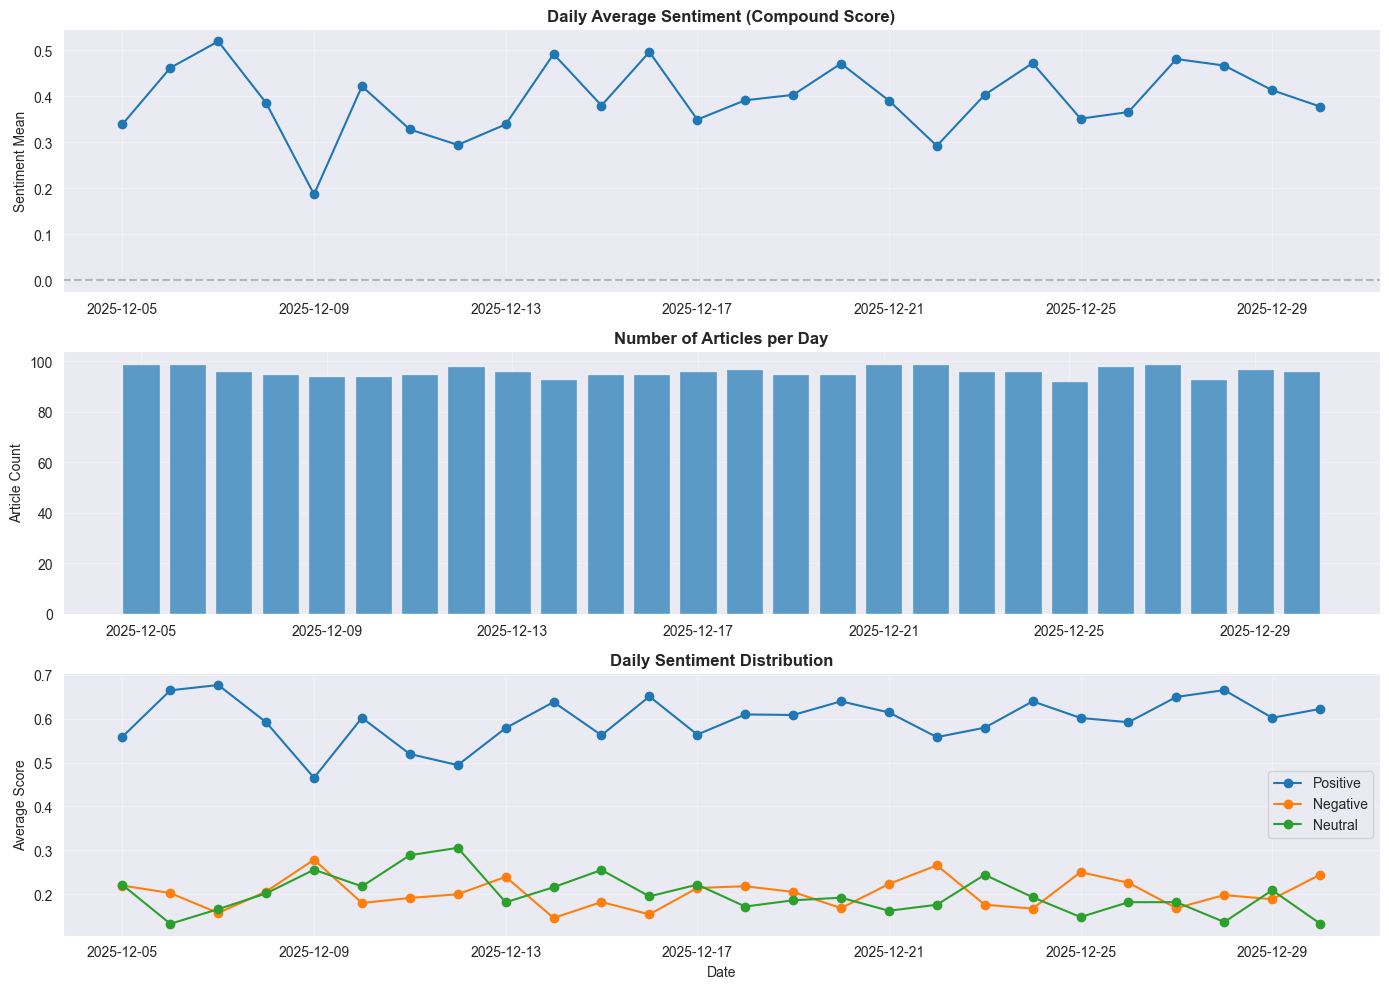


✓ Sentiment trends visualized


In [6]:
if daily_sentiment is not None and len(daily_sentiment) > 0:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Convert date to datetime for plotting
    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
    
    # 1. Sentiment mean over time
    axes[0].plot(daily_sentiment['date'], daily_sentiment['sentiment_mean'], marker='o')
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title('Daily Average Sentiment (Compound Score)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Sentiment Mean')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Article count per day
    axes[1].bar(daily_sentiment['date'], daily_sentiment['article_count'], alpha=0.7)
    axes[1].set_title('Number of Articles per Day', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Article Count')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Sentiment distribution (positive/negative/neutral)
    axes[2].plot(daily_sentiment['date'], daily_sentiment['positive_mean'], label='Positive', marker='o')
    axes[2].plot(daily_sentiment['date'], daily_sentiment['negative_mean'], label='Negative', marker='o')
    axes[2].plot(daily_sentiment['date'], daily_sentiment['neutral_mean'], label='Neutral', marker='o')
    axes[2].set_title('Daily Sentiment Distribution', fontsize=12, fontweight='bold')
    axes[2].set_ylabel('Average Score')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Sentiment trends visualized")
else:
    print("⚠️  Skipping visualization - no sentiment data available")

## Upload Daily Sentiment Features to Hopsworks

**Key**: Upload ONLY the aggregated daily metrics (numeric columns), no text columns.

This avoids the "loadbalancer_external_domain_datanode not found" error in Hopsworks free tier.

In [7]:
if daily_sentiment is not None and len(daily_sentiment) > 0:
    print("Uploading daily sentiment features to Hopsworks...\n")
    
    # Connect to Hopsworks
    fs = get_feature_store()
    
    # Ensure date is in correct format
    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
    
    # Verify all columns are numeric (except date)
    print("Feature group schema:")
    print(daily_sentiment.dtypes)
    print()
    
    # Create feature group with daily sentiment metrics
    sentiment_fg = create_feature_group(
        fs,
        name='sentiment_features',
        df=daily_sentiment,
        primary_key=['date'],
        description='Daily aggregated news sentiment from NewsAPI + FinBERT (no text columns)'
    )
    
    print(f"\n✓ Sentiment features uploaded to Hopsworks!")
    print(f"  Feature group: sentiment_features (version {sentiment_fg.version})")
    print(f"  Features: {len(daily_sentiment.columns) - 1}")  # -1 for date column
    print(f"  Samples: {len(daily_sentiment)}")
else:
    print("\n⚠️  Skipping Hopsworks upload - no sentiment data available")
    print("\nTo complete this step:")
    print("1. Get a valid NewsAPI key from https://newsapi.org/register")
    print("2. Update NEWS_API_KEY in your .env file")
    print("3. Re-run this notebook")
    print("\nOr use alternative news source (Finnhub, Alpha Vantage, etc.)")

Uploading daily sentiment features to Hopsworks...

2026-01-05 16:57:59,121 INFO: Initializing external client
2026-01-05 16:57:59,122 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-05 16:58:00,482 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272010
Feature group schema:
date              datetime64[ns]
sentiment_mean           float64
sentiment_std            float64
article_count              int64
positive_mean            float64
negative_mean            float64
neutral_mean             float64
dtype: object


Creating feature group: sentiment_features
Data shape (before deduplication): (26, 7)
Data shape (after deduplication): (26, 7)
Columns: ['date', 'sentiment_mean', 'sentiment_std', 'article_count', 'positive_mean', 'negative_mean', 'neutral_mean']
Data types:
date              datetime64[ms]
sentiment_mean           float64
sentiment_std            float64
article_count              int64
positive_mean       

Uploading Dataframe: 0.00% |          | Rows 0/26 | Elapsed Time: 00:00 | Remaining Time: ?huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Uploading Dataframe: 100.00% |██████████| Rows 26/26 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: sentiment_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1272010/jobs/named/sentiment_features_1_offline_fg_materialization/executions
2026-01-05 16:58:17,839 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2026-01-05 16:58:24,245 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2026-01-05 17:00:06,791 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2026-01-05 17:00:10,164 INFO: Waiting for log aggregation to finish.
2026-01-05 17:01:53,361 INFO: Execution finished successfully.
✓ Insert job completed
  Job details: (Job('sentiment_features_1_offline_fg_materialization', 'SPARK'), None)

Waiting for data to be committed (10 seconds)...

✓ Upload completed successfully
  Job finished with status: SUCCEEDED
  Uploaded 26 rows to 'sentiment_features'

⚠️  NOTE: Data is in

## Summary

**✅ Daily sentiment features created (if news data available)**:

**Feature Group**: `sentiment_features`
- `sentiment_mean`: Average daily compound sentiment (-1 to +1)
- `sentiment_std`: Sentiment volatility (dispersion)
- `article_count`: Number of articles analyzed
- `positive_mean`: Average positive score
- `negative_mean`: Average negative score
- `neutral_mean`: Average neutral score

**Key Design Decisions**:
1. **No text columns**: Only numeric features to avoid Hopsworks free tier limitations
2. **Daily aggregation**: Article-level data aggregated to daily metrics
3. **FinBERT**: Financial-domain sentiment model for accurate market sentiment
4. **Missing days**: Days with no news will not appear (can be filled with 0 during feature view creation)

**Next steps**:
- Notebook 4: Create market features (QQQ technical, XLK sector, VIX volatility)
- Notebook 5: Create macro features (DGS10, CPI)
- Notebook 6: Join all features into feature view
- Notebook 7: Train models

**Note**: If you don't have a valid NewsAPI key, you can skip this notebook and proceed without sentiment features. The model will still work with market and macro features only.